## DSAN 5650: Propensity Score Lab

In [113]:
%run jupyter_fixes.ipynb

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patchworklib as pw
import graphviz as gr

import statsmodels.formula.api as smf

## [Part 1] Load Data

In [115]:
student_df = pd.read_csv("learning_mindset.csv")
student_df.head()

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277359,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.449646,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.769703,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.121763,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,1.526147,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


## Codebook

* `schoolid`: identifier of the student’s school;
* `success_expect`: self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment;
* `ethnicity`: categorical variable for student race/ethnicity;
* `gender`: categorical variable for student identified gender;
* `frst_in_family`: categorical variable for student first-generation status, i.e. first in family to go to college;
* `school_urbanicity`: school-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc;
* `school_mindset`: school-level mean of students’ fixed mindsets, reported prior to random assignment, standardized;
* `school_achievement`: school achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students, standardized;
* `school_ethnic_minority`: school racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American, standardized;
* `school_poverty`: school poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line, standardized;
* `school_size`: total number of students in all four grade levels in the school, standardized.

In [116]:
student_df.describe()

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
count,10391.000000,10391.000000,1.039100e+04,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000
mean,39.888846,0.325666,3.829313e-17,5.268117,5.223078,1.489943,0.630931,2.447791,-0.040457,0.054841,-0.089349,-0.045911,-0.026168
std,24.008975,0.468646,1.000000e+00,1.120765,3.982963,0.499923,0.482576,1.378420,0.969743,0.935560,0.962804,0.967262,1.010387
min,1.000000,0.000000,-3.111431e+00,1.000000,1.000000,1.000000,0.000000,0.000000,-3.088790,-3.347819,-1.575463,-1.924778,-1.805073
25%,19.000000,0.000000,-7.033152e-01,5.000000,3.000000,1.000000,0.000000,1.000000,-0.617888,-0.544506,-0.963095,-0.813799,-0.857026
50%,41.000000,0.000000,-3.449486e-02,5.000000,4.000000,1.000000,1.000000,2.000000,-0.009954,-0.022514,-0.057036,-0.159602,-0.211553
75%,62.000000,1.000000,6.724723e-01,6.000000,5.000000,2.000000,1.000000,4.000000,0.420441,0.726836,0.515392,0.596474,0.847844
max,76.000000,1.000000,3.563639e+00,7.000000,15.000000,2.000000,1.000000,4.000000,2.834589,2.171815,2.358274,2.821660,1.892348


In [117]:
student_df.apply(lambda x: len(pd.unique(x)))

schoolid                     76
intervention                  2
achievement_score         10391
success_expect                7
ethnicity                    15
gender                        2
frst_in_family                2
school_urbanicity             5
school_mindset               76
school_achievement           76
school_ethnic_minority       76
school_poverty               76
school_size                  76
dtype: int64

In [118]:
student_df[student_df['achievement_score'] < -3]

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
7140,36,0,-3.111431,4,4,2,1,1,1.731915,-0.587886,-0.986201,0.540381,-1.606304


In [119]:
student_df[student_df['achievement_score'] > 3.5]

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
1674,43,1,3.563639,7,12,1,0,0,-0.568329,0.613465,-1.21021,-0.66486,-1.481989


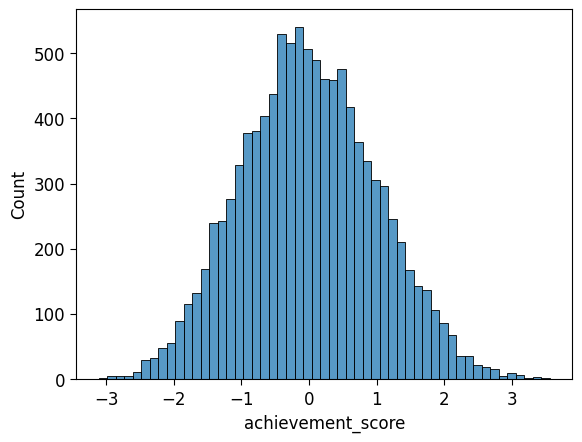

In [120]:
sns.histplot(
    x="achievement_score", data=student_df
);

## [Part 2] Compute Naïve ATE

In [180]:
group_means = student_df.groupby('intervention')['achievement_score'].mean().to_frame()
group_means

,achievement_score
intervention,
0,-0.153803
1,0.318469


In [181]:
avg_treatment_effect = group_means.loc[1, 'achievement_score'] - group_means.loc[0, 'achievement_score']
print(avg_treatment_effect)

0.47227166925168707


In [182]:
smf.ols("achievement_score ~ intervention", data=student_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


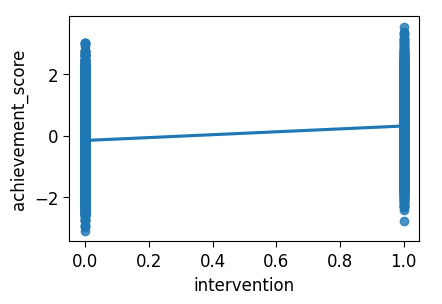

In [183]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.regplot(x="intervention", y="achievement_score", data=student_df, ax=ax);
ax.savefig()

## Inverse Probability of Treatment Weighting (IPTW)

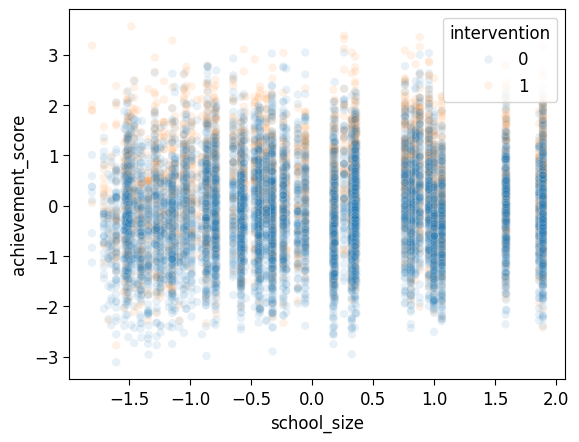

In [185]:
sns.scatterplot(
    x="school_size", y="achievement_score", hue="intervention",
    data=student_df,
    alpha=0.1,
);

## Messy/Impossible to See the Pattern... Coarse-Graining Time!

In [186]:
school_df = student_df.groupby('schoolid').mean()
school_df

,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,size_bin,propensity_score
schoolid,,,,,,,,,,,,,,
1,0.333333,-0.449531,5.055556,5.791667,1.472222,0.805556,3.0,1.185986,-1.129889,1.009875,1.005063,-1.174702,-1.0,0.295605
2,0.355140,0.229476,5.289720,4.937695,1.485981,0.778816,4.0,0.208298,-0.122386,1.199492,-0.337134,0.352747,0.0,0.341383
3,0.363184,0.583921,5.527363,5.154229,1.482587,0.462687,2.0,-2.081630,2.171815,-0.145265,-0.785322,0.882281,1.0,0.382307
4,0.380137,0.413153,5.109589,4.222603,1.441781,0.671233,0.0,-2.289636,0.190797,0.875012,-0.724801,0.761781,1.0,0.369316
5,0.328042,0.052769,4.873016,4.465608,1.439153,0.867725,0.0,-0.055150,-0.544506,1.302587,-1.735164,-0.792146,-1.0,0.321202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.309013,-0.100439,5.167382,5.090129,1.497854,0.738197,3.0,0.420441,-0.491972,-0.913405,-0.043159,-0.438531,0.0,0.297773
73,0.307407,-0.407368,5.551852,5.525926,1.518519,0.425926,1.0,-0.462945,0.652608,-0.515202,-0.169849,0.173954,0.0,0.324419
74,0.317829,-0.417852,5.174419,6.461240,1.461240,0.724806,4.0,0.983982,-0.449943,0.088159,-0.657131,-0.323959,0.0,0.316256


In [187]:
med_size = school_df['school_size'].median()
med_size

-0.861296024346554

In [188]:
school_df['above_med_size'] = school_df['school_size'] > med_size
school_df['above_mean_size'] = school_df['school_size'] > 0.0

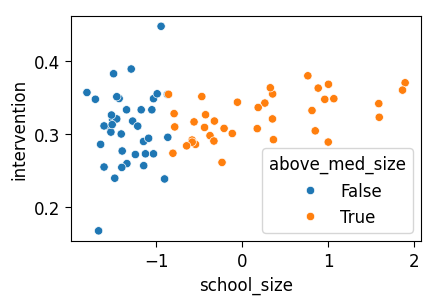

In [191]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.scatterplot(
    x="school_size", y="intervention", hue='above_med_size', data=school_df, ax=ax,
);
ax.savefig()

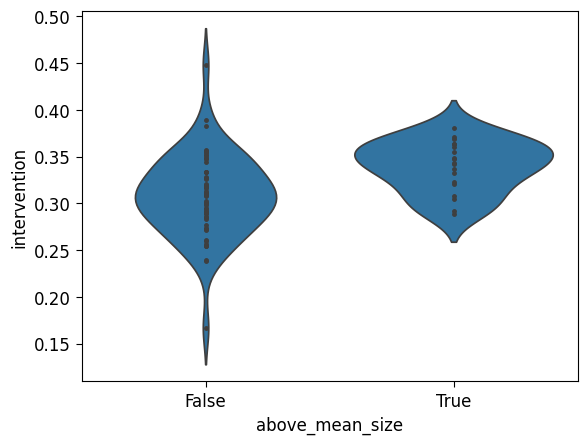

In [192]:
sns.violinplot(
    x='above_mean_size', y='intervention', data=school_df, inner='point'
);

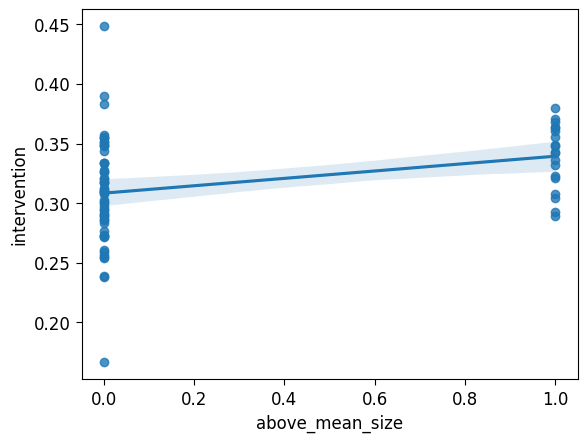

In [193]:
sns.regplot(
    x='above_mean_size', y='intervention', data=school_df
);

## It looks like there's a relationship... let's check with OLS

Using `statsmodels` as alternative to `lm` in Python

In [137]:
smf.ols("intervention ~ school_size", data=student_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3261,0.005,70.941,0.000,0.317,0.335
school_size,0.0159,0.005,3.493,0.000,0.007,0.025


In [138]:
smf.ols("intervention ~ school_poverty", data=student_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3254,0.005,70.702,0.000,0.316,0.334
school_poverty,-0.0057,0.005,-1.190,0.234,-0.015,0.004


In [139]:
smf.ols("intervention ~ school_urbanicity", data=student_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3209,0.009,34.244,0.000,0.303,0.339
school_urbanicity,0.0020,0.003,0.587,0.557,-0.005,0.008


In [140]:
smf.ols("intervention ~ school_ethnic_minority", data=student_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3256,0.005,70.509,0.000,0.317,0.335
school_ethnic_minority,-0.0011,0.005,-0.231,0.818,-0.010,0.008


In [141]:
smf.ols("intervention ~ school_achievement", data=student_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3249,0.005,70.573,0.000,0.316,0.334
school_achievement,0.0140,0.005,2.845,0.004,0.004,0.024


In [142]:
smf.ols("intervention ~ school_mindset", data=student_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3248,0.005,70.651,0.000,0.316,0.334
school_mindset,-0.0223,0.005,-4.703,0.000,-0.032,-0.013


## Plotting the IPTW

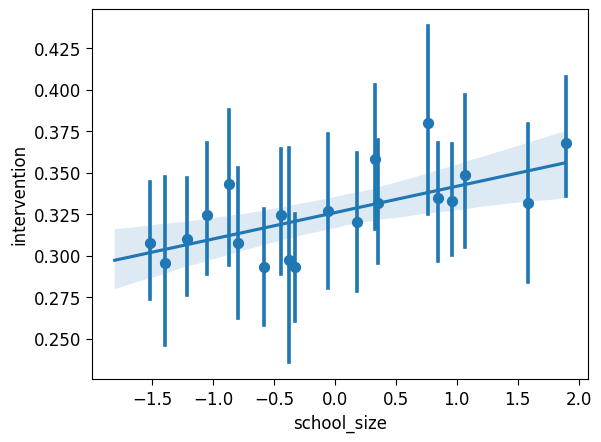

In [143]:
# Before
sns.regplot(
    x="school_size", y="intervention", x_bins=20, data=student_df
);

In [144]:
student_df['intervention'].value_counts()

intervention
0    7007
1    3384
Name: count, dtype: int64

## Now for *all* covariates: Scikit-learn time :)

In [149]:
from sklearn.linear_model import LogisticRegression

Prepare data for sklearn

In [156]:
id_var = 'schoolid'
treatment_var = 'intervention'
categorical_covars = [
    'success_expect', 'ethnicity', 'gender', 'frst_in_family', 'school_urbanicity'
]
continuous_covars = [
    'school_mindset', 'school_achievement', 'school_ethnic_minority', 'school_poverty',
    'school_size'
]
dummy_df = pd.get_dummies(student_df[categorical_covars], columns=categorical_covars, drop_first=False)
continuous_df = student_df[continuous_covars]
X_df = pd.concat([continuous_df, dummy_df], axis=1)
X_df

,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,success_expect_1,success_expect_2,success_expect_3,success_expect_4,success_expect_5,...,ethnicity_15,gender_1,gender_2,frst_in_family_0,frst_in_family_1,school_urbanicity_0,school_urbanicity_1,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
0,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,True
1,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,True
2,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,True
3,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,True
4,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,False,False,False,...,False,True,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
10387,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
10388,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,True,False,False,False,...,True,True,False,False,True,False,False,False,True,False
10389,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,False,False,False,True,...,False,True,False,False,True,False,False,False,True,False


In [157]:
y_df = student_df['intervention']

In [158]:
lr_model = LogisticRegression().fit(X_df, y_df)

In [161]:
student_df['propensity_score'] = lr_model.predict_proba(X_df)[:,1]
student_df

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,size_bin,propensity_score
0,76,1,0.277359,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,-0.0,0.323723
1,76,1,-0.449646,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,-0.0,0.242929
2,76,1,0.769703,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,-0.0,0.351739
3,76,1,-0.121763,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,-0.0,0.351739
4,76,1,1.526147,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,-0.0,0.376521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1,0,0.808867,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,-1.0,0.314879
10387,1,0,-0.156063,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,-1.0,0.314879
10388,1,0,0.370820,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,-1.0,0.266406
10389,1,0,-0.396297,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,-1.0,0.298979


## *Important!* Balance Plot

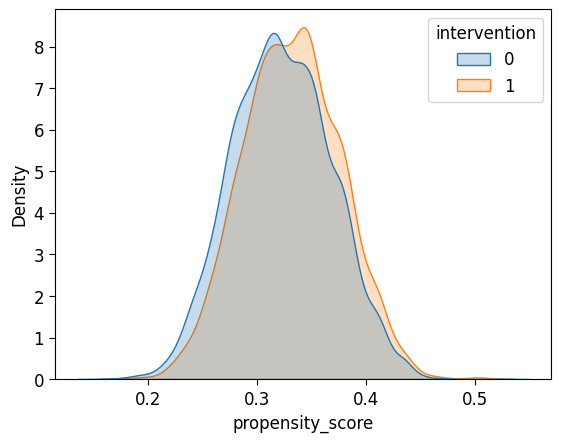

In [179]:
sns.kdeplot(
    x='propensity_score', hue='intervention', data=student_df,
    #stat='probability',
    common_norm=False,
    fill=True,
);

## Counterfactual 1: *Everyone* took the seminar

In [200]:
weight_t = 1/student_df.query("intervention==1")["propensity_score"]
y1 = sum(student_df.query("intervention==1")["achievement_score"]*weight_t) / len(student_df)
print("Y1:", y1)

Y1: 0.25648113094308067


## Counterfactual 2: *Nobody* took the seminar

In [201]:
weight_nt = 1/(1-student_df.query("intervention==0")["propensity_score"])
y0 = sum(student_df.query("intervention==0")["achievement_score"]*weight_nt) / len(student_df)
print("Y0:", y0)

Y0: -0.12738115849967555


## Counterfactual 3: *Everyone both took and didn't take the seminar* 🤯

In [202]:
weight = (
    (student_df["intervention"]-student_df["propensity_score"]) /
    (student_df["propensity_score"]*(1-student_df["propensity_score"]))
)
ate = np.mean(weight * student_df["achievement_score"])
print("ATE:", ate)

ATE: 0.3838622894427562
